# Data Preparation for EMNIST Letters Dataset

## Load the Dataset

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('../emnist-letters-train.csv')

# Check the shape and first few rows
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (64828, 785)


,24,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561
0,-2,142,142,142,142,142,142,142,142,142,...,142,142,142,142,142,142,142,142,142,142
1,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-2,120,120,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120
4,-1,131,131,131,131,131,131,131,131,200,...,131,131,131,131,131,131,131,131,131,131


## Understanding the Data Structure

Unique labels: [-2 -1  1  2  4  5  6  7  9 10 12 14 15 16 17 20 24 26]


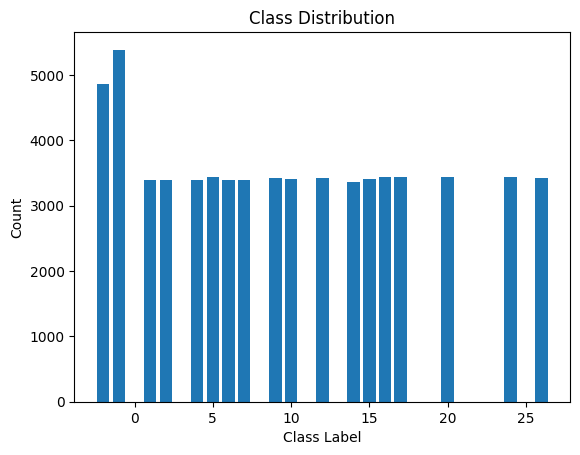

Unique labels before cleaning: [-2 -1  1  2  4  5  6  7  9 10 12 14 15 16 17 20 24 26]
Label counts before cleaning: [4856 5384 3396 3396 3398 3437 3394 3385 3428 3402 3415 3365 3408 3430
 3435 3436 3436 3427]
Total images before cleaning: 64828
Corresponding letters: ['>', '?', 'A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']


In [9]:
# Separate labels and pixel data
labels = data.iloc[:, 0].values
pixels = data.iloc[:, 1:].values

# Check label distribution
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"Unique labels: {unique_labels}")

# Visualize class distribution
plt.bar(unique_labels, counts)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

print(f"Unique labels before cleaning: {unique_labels}")
print(f"Label counts before cleaning: {counts}")
print(f"Total images before cleaning: {len(pixels)}")
print(f"Corresponding letters: {[chr(l+64) for l in unique_labels]}")

In [10]:
# Reshape and normalize
images = pixels.reshape(-1, 28, 28, 1).astype('float32')
images = (images - 127.5) / 127.5  # Normalize to [-1, 1]

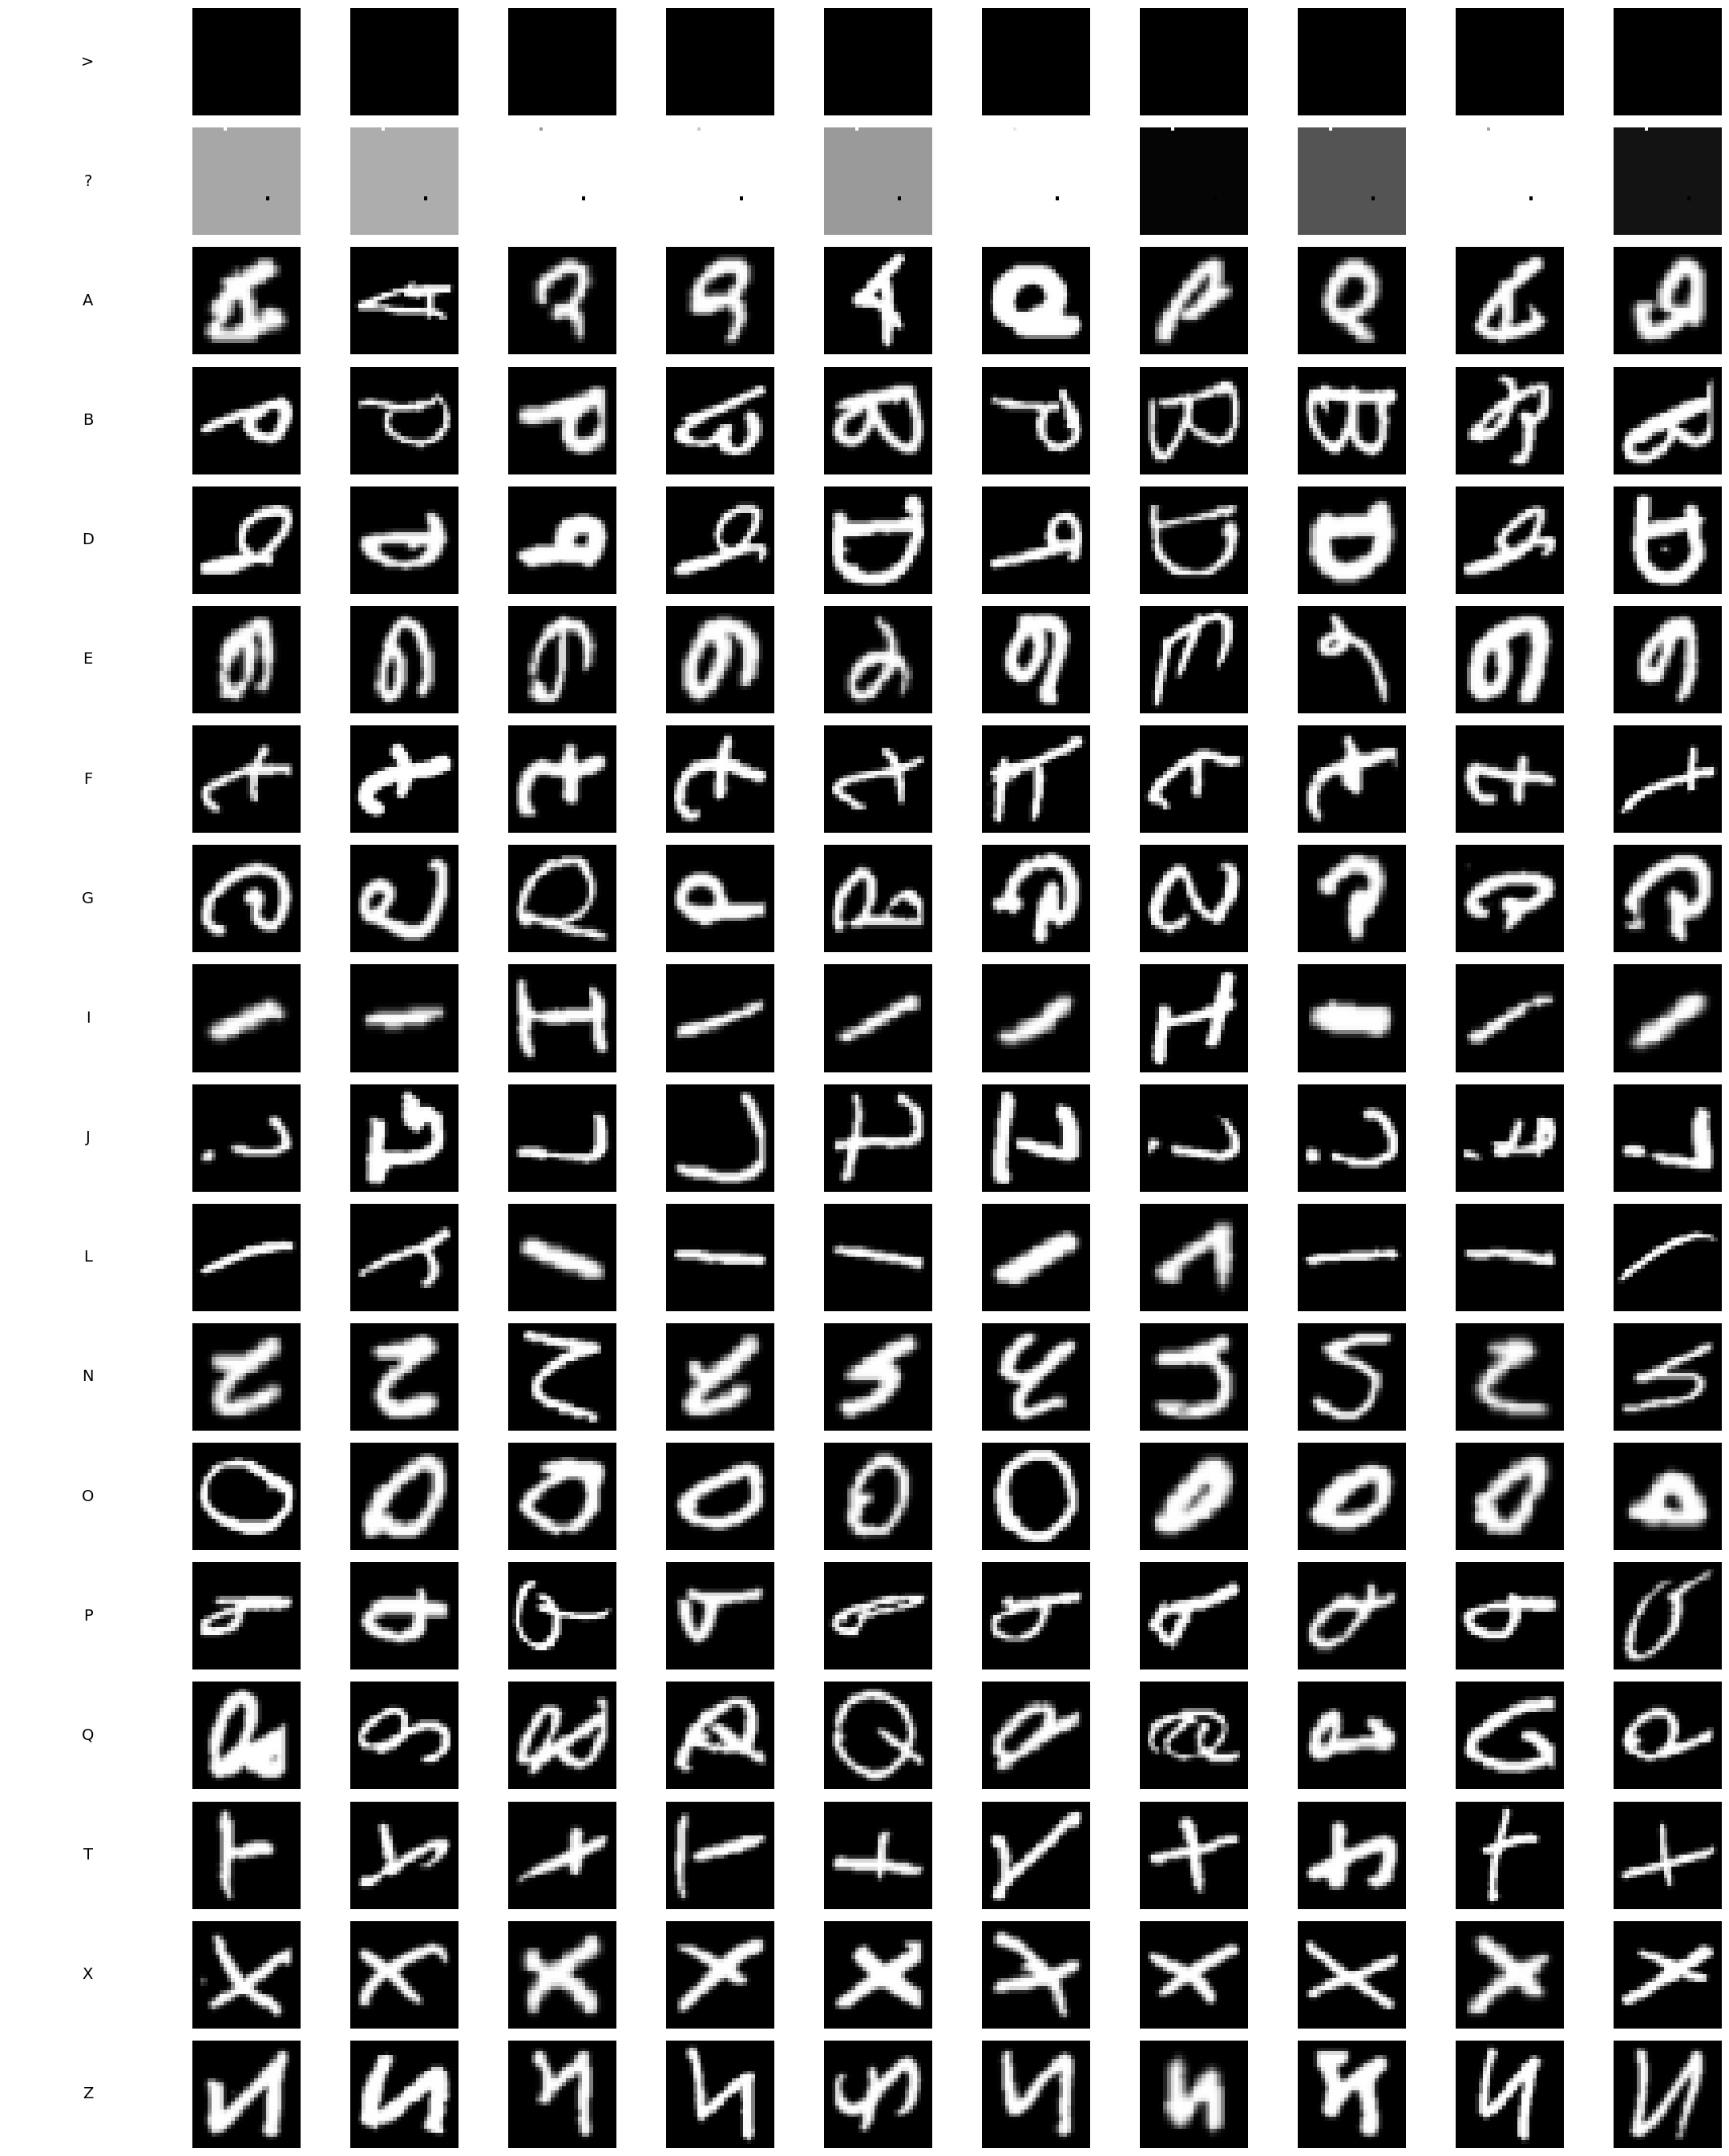

In [11]:
# Get all unique class labels
unique_labels_to_show = np.sort(np.unique(labels))
num_classes = len(unique_labels_to_show)

# Set number of columns and compute required rows dynamically
cols = 11  # 1 for label + 10 for sample images
rows = math.ceil(num_classes / 1)  # Each class gets its own row

plt.figure(figsize=(cols * 2, rows * 1.5))  # Adjust figure size

for idx, class_label in enumerate(unique_labels_to_show):
  class_indices = np.nonzero(labels == class_label)[0][:10]  # Get 10 samples

  # Label subplot
  plt.subplot(rows, cols, idx * cols + 1)
  plt.text(0.5, 0.5, f"{chr(class_label + 64)}", fontsize=14, ha='center', va='center')
  plt.axis('off')

  # Show 10 example images
  for i, img_idx in enumerate(class_indices):
    plt.subplot(rows, cols, idx * cols + i + 2)
    plt.imshow(images[img_idx].squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Data Cleaning

In [12]:
# First filter out negative labels
valid_mask = labels > 0
filtered_images = images[valid_mask]
filtered_labels = labels[valid_mask]

# Then select only our 16 target classes
selected_numeric = [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 16, 17, 20, 24, 26]  # A, B, D, E, F, G, I, J, L, N, O, P, Q, T, X, Z
final_mask = np.isin(filtered_labels, selected_numeric)
final_images = filtered_images[final_mask]
final_labels = filtered_labels[final_mask]

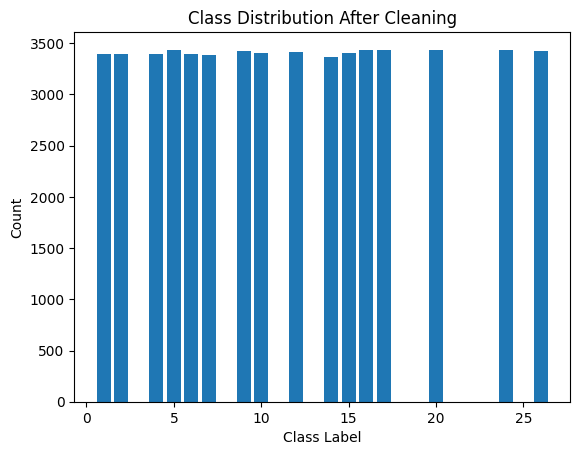

Unique labels after cleaning: [ 1  2  4  5  6  7  9 10 12 14 15 16 17 20 24 26]
Label counts after cleaning: [3396 3396 3398 3437 3394 3385 3428 3402 3415 3365 3408 3430 3435 3436
 3436 3427]
Total images after cleaning: 54588
Corresponding letters: ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']


In [13]:
# Show class distribution after cleaning
unique_labels_cleaned, counts_cleaned = np.unique(final_labels, return_counts=True)
plt.bar(unique_labels_cleaned, counts_cleaned)
plt.title('Class Distribution After Cleaning')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

print(f"Unique labels after cleaning: {unique_labels_cleaned}")
print(f"Label counts after cleaning: {counts_cleaned}")
print(f"Total images after cleaning: {len(final_images)}")
print(f"Corresponding letters: {[chr(l+64) for l in unique_labels_cleaned]}")


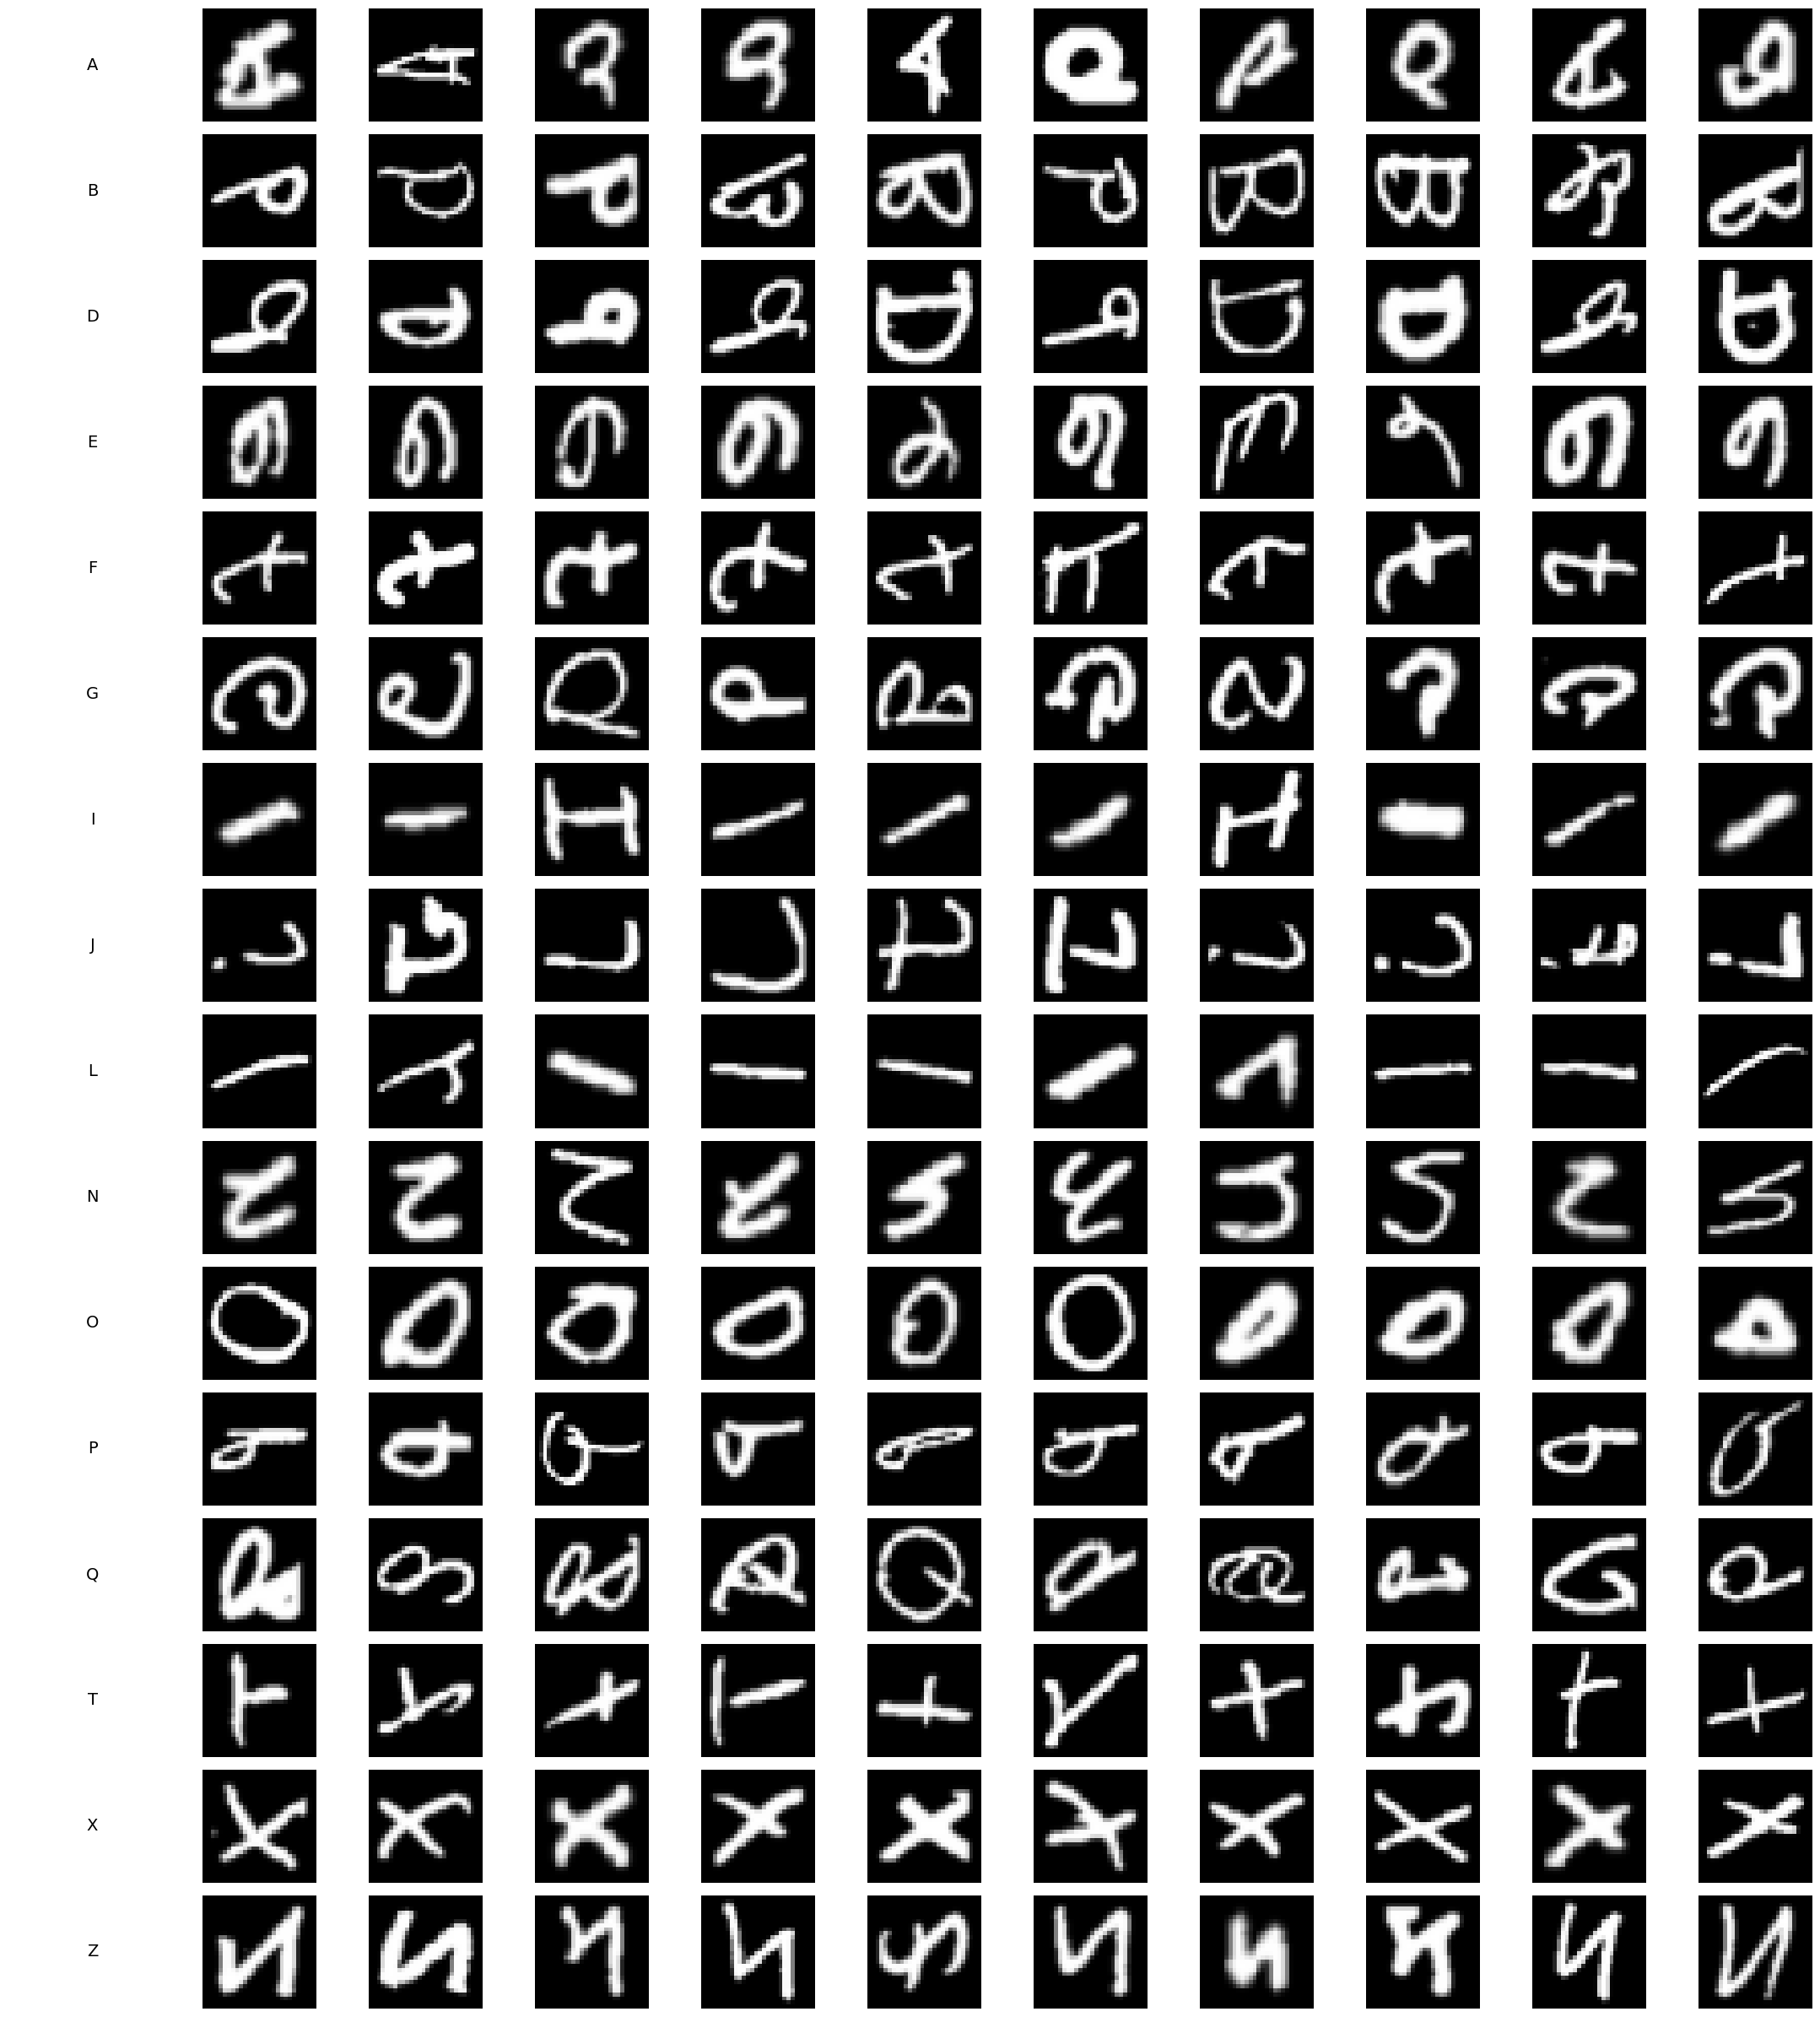

In [14]:
# Get all unique class labels from cleaned data
unique_labels_to_show = np.sort(np.unique(final_labels))
num_classes = len(unique_labels_to_show)

# Set number of columns and compute required rows dynamically
cols = 11  # 1 for label + 10 for sample images
rows = math.ceil(num_classes / 1)  # Each class gets its own row

plt.figure(figsize=(cols * 2, rows * 1.5))  # Adjust figure size

for idx, class_label in enumerate(unique_labels_to_show):
  class_indices = np.nonzero(final_labels == class_label)[0][:10]  # Get 10 samples

  # Label subplot
  plt.subplot(rows, cols, idx * cols + 1)
  plt.text(0.5, 0.5, f"{chr(class_label + 64)}", fontsize=14, ha='center', va='center')
  plt.axis('off')

  # Show 10 example images
  for i, img_idx in enumerate(class_indices):
    plt.subplot(rows, cols, idx * cols + i + 2)
    plt.imshow(final_images[img_idx].squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Preparing for Conditional GAN

In [15]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding (for 16 classes)
selected_letters = ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']

# Convert letters to their label values (A=1, B=2, ..., Z=26)
selected_labels = [ord(c) - 64 for c in selected_letters]

# Now convert to 0-15 range for one-hot encoding
label_mapping = {label: idx for idx, label in enumerate(selected_labels)}
mapped_labels = np.array([label_mapping[label] for label in filtered_labels])

# One-hot encode (now safe with 16 classes)
one_hot_labels = to_categorical(mapped_labels, num_classes=16)

In [16]:
integer_labels = np.argmax(one_hot_labels, axis=1)
labels = integer_labels[idx].reshape(-1, 1)

## Data Verification 

In [17]:
# Check Basic Shapes & Types
print("Total samples:", len(final_images))
print("Image shape:", final_images.shape[1:])
print("Labels shape:", one_hot_labels.shape)
print("Image dtype:", final_images.dtype)
print("Label dtype:", one_hot_labels.dtype)


Total samples: 54588
Image shape: (28, 28, 1)
Labels shape: (54588, 16)
Image dtype: float32
Label dtype: float32


In [18]:
# Check pixel value range
print("Pixel value range:", final_images.min(), "to", final_images.max())

Pixel value range: -1.0 to 1.0


In [19]:
# Check label classes and distribution
# If labels are one-hot encoded, convert back to class indices
labels_int = np.argmax(one_hot_labels, axis=1)

print("Label classes in dataset:", np.unique(labels_int))
print("Label distribution:")
unique, counts = np.unique(labels_int, return_counts=True)
print(dict(zip(unique, counts)))


Label classes in dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label distribution:
{0: 3396, 1: 3396, 2: 3398, 3: 3437, 4: 3394, 5: 3385, 6: 3428, 7: 3402, 8: 3415, 9: 3365, 10: 3408, 11: 3430, 12: 3435, 13: 3436, 14: 3436, 15: 3427}


In [20]:
print("Labels shape:", labels.shape)
print("Labels example:", labels[0])

# Check if labels look like one-hot vectors
if len(labels.shape) == 2 and labels.shape[1] > 1:
    print("Likely one-hot encoded")
elif len(labels.shape) == 1 or (len(labels.shape) == 2 and labels.shape[1] == 1):
    print("Likely integer labels")
else:
    print("Unknown label format")


Labels shape: (1, 1)
Labels example: [12]
Likely integer labels


In [21]:
print("Labels shape:", mapped_labels.shape)
print("Labels example:", mapped_labels[0])

# Check if labels look like one-hot vectors
if len(mapped_labels.shape) == 2 and mapped_labels.shape[1] > 1:
    print("Likely one-hot encoded")
elif len(mapped_labels.shape) == 1 or (len(labels.shape) == 2 and labels.shape[1] == 1):
    print("Likely integer labels")
else:
    print("Unknown label format")

Labels shape: (54588,)
Labels example: 10
Likely integer labels


# Base Model

## Model Building

In [22]:
def build_generator(latent_dim=100, num_classes=16):
    # Conditional input
    label_input = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, 50)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    
    # Noise input
    noise_input = layers.Input(shape=(latent_dim,))
    
    # Combined input
    combined = layers.Concatenate()([noise_input, label_embedding])
    
    # Generator network
    x = layers.Dense(7*7*256, use_bias=False)(combined)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Reshape((7, 7, 256))(x)
    
    x = layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')(x)
    
    return models.Model([noise_input, label_input], x, name='generator')

def build_discriminator(img_shape=(28,28,1), num_classes=16):
    # Image input
    img_input = layers.Input(shape=img_shape)
    
    # Label input
    label_input = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, 50)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Dense(np.prod(img_shape))(label_embedding)
    label_embedding = layers.Reshape(img_shape)(label_embedding)
    
    # Combined input
    combined = layers.Concatenate()([img_input, label_embedding])
    
    # Discriminator network
    x = layers.Conv2D(64, (5,5), strides=(2,2), padding='same')(combined)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (5,5), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model([img_input, label_input], x, name='discriminator')

# Build and compile
latent_dim = 100
img_shape = (28,28,1)
num_classes = 16

generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator(img_shape, num_classes)

discriminator.compile(
    optimizer=optimizers.Adam(0.0002, 0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Combined GAN
discriminator.trainable = False
noise = layers.Input(shape=(latent_dim,))
label = layers.Input(shape=(1,))
img = generator([noise, label])
validity = discriminator([img, label])
gan = models.Model([noise, label], validity)
gan.compile(
    optimizer=optimizers.Adam(0.0002, 0.5),
    loss='binary_crossentropy'
)

## Model Training

In [23]:
def train_gan(epochs, batch_size=128, sample_interval=50):
    # Load and normalize data
    X_train, y_train = final_images, mapped_labels  # From your data prep
    
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size)
        gen_imgs = generator.predict([noise, gen_labels.reshape(-1,1)], verbose=0)
        
        d_loss_real = discriminator.train_on_batch([imgs, labels.reshape(-1,1)], valid)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, gen_labels.reshape(-1,1)], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.random.randint(0, num_classes, batch_size)
        g_loss = gan.train_on_batch([noise, valid_labels.reshape(-1,1)], valid)
        
        # Print progress
        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
            sample_images(epoch)
    
    # Save weights
    generator.save_weights('base_generator.weights.h5')
    discriminator.save_weights('base_discriminator.weights.h5')

def sample_images(epoch):
    r, c = 4, 4
    noise = np.random.normal(0, 1, (r*c, latent_dim))
    sampled_labels = np.arange(0, num_classes).reshape(-1,1)
    
    gen_imgs = generator.predict([noise, sampled_labels])
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to 0-1

    selected_letters = ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].set_title(f"Label: {selected_letters[sampled_labels[cnt][0]]}")
            axs[i,j].axis('off')
            cnt += 1
    plt.tight_layout()
    plt.savefig(f"base_images_sample/epoch_{epoch}.png")
    plt.close()

In [24]:
# Create directory for samples
import os
os.makedirs("base_images_sample", exist_ok=True)

# Train the model
train_gan(epochs=5000, batch_size=32, sample_interval=100)

0 [D loss: 0.6668, acc.: 45.31%] [G loss: 0.6468]
1/1 [==============================] - 0s 144ms/step
100 [D loss: 0.0904, acc.: 98.44%] [G loss: 0.0053]
1/1 [==============================] - 0s 19ms/step
200 [D loss: 0.0025, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 20ms/step
300 [D loss: 0.0062, acc.: 100.00%] [G loss: 0.0015]
1/1 [==============================] - 0s 21ms/step
400 [D loss: 0.0313, acc.: 100.00%] [G loss: 0.0588]
1/1 [==============================] - 0s 18ms/step
500 [D loss: 0.6697, acc.: 62.50%] [G loss: 0.8639]
1/1 [==============================] - 0s 19ms/step
600 [D loss: 0.7813, acc.: 43.75%] [G loss: 0.8254]
1/1 [==============================] - 0s 19ms/step
700 [D loss: 0.7838, acc.: 31.25%] [G loss: 0.7358]
1/1 [==============================] - 0s 19ms/step
800 [D loss: 0.6262, acc.: 70.31%] [G loss: 0.7611]
1/1 [==============================] - 0s 18ms/step
900 [D loss: 0.7132, acc.: 43.75%] [G loss: 0.7856]
1/1 [=====